In [1]:
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [2]:
import json
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame

import seaborn as sns

sns.set_theme()

In [33]:
MODELS = [
    "Beta_CDR_Levenshtein",
    "Beta_tcrdist",
    "Beta_CDR_BERT_Large"
]

MODEL_NAME_TRANSLATOR = {
    "Beta_CDR_Levenshtein": "Levenshtein",
    "Beta_tcrdist": "tcrdist",
    "Beta_CDR_BERT_Large": "BLAsTR (ours)"
}

In [34]:
def read_precision_recall_results(model_name: str) -> dict:
    benchmarks_path = Path("/home/yutanagano/Projects/tcr_embedder/benchmarks")
    with open(benchmarks_path/model_name/"precision_recall"/"results.json", "r") as f:
        return json.load(f)

precision_recall_dict = {
    MODEL_NAME_TRANSLATOR[model_name]: read_precision_recall_results(model_name) for model_name in MODELS
}

In [57]:
def get_precision(data: dict) -> ndarray:
    return np.array(data["avg_precision_gdb_holdout"]["precisions"])

def get_recall(data: dict) -> ndarray:
    return np.array(data["avg_precision_gdb_holdout"]["recalls"])

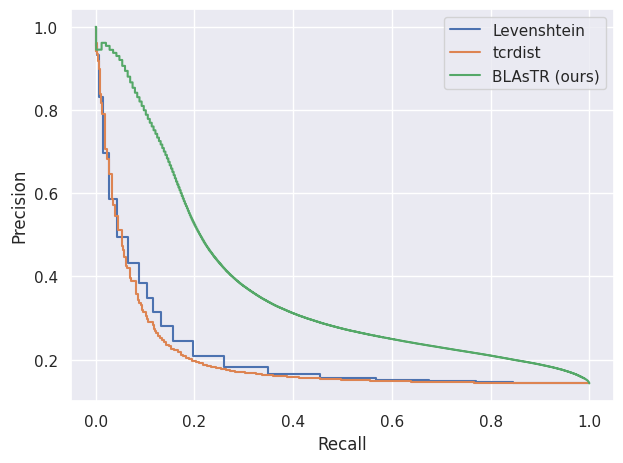

In [58]:
plt.figure()

for model_name, data in precision_recall_dict.items():
    precision = get_precision(data)
    recall = get_recall(data)

    plt.step(recall, precision, label=model_name)

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend()

plt.tight_layout()

plt.savefig("linear_scale.png")

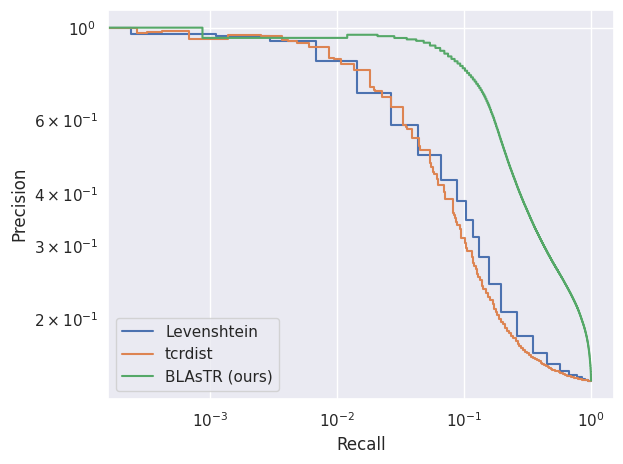

In [59]:
plt.figure()

for model_name, data in precision_recall_dict.items():
    precision = get_precision(data)
    recall = get_recall(data)

    plt.step(recall, precision, label=model_name)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend()

plt.tight_layout()

plt.savefig("log_scale.png")

### Export raw data for Maddy

In [42]:
max_length = 0
for _, data in precision_recall_dict.items():
    precisions = get_precision(data)
    if len(precisions) > max_length:
        max_length = len(precisions)

export = DataFrame()

for model_name, data in precision_recall_dict.items():
    precisions = list(get_precision(data))
    recalls = list(get_recall(data))

    if len(precisions) < max_length:
        precisions.extend([None] * (max_length - len(precisions)))
        recalls.extend([None] * (max_length - len(recalls)))

    export[f"precisions: {model_name}"] = precisions
    export[f"recalls: {model_name}"] = recalls

In [51]:
export.to_csv("pr_curve_data.csv", index=False)